In [10]:
import torch
import torchvision
from torchvision.datasets import MNIST
import torch.nn as nn

In [372]:
# hyperparameters

device = 'mps' if torch.mps.is_available() else 'cpu'
num_epochs = 20
batch_size = 64
learning_rate = 1e-3
layer_size = 256

In [393]:
from torch.utils.data import DataLoader
train_loader = DataLoader(
    MNIST('../', train=True, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size,
    shuffle=True,
)

test_loader = DataLoader(
    MNIST('../', train=False, download=True, transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize((0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size,
    shuffle=True,
)

In [388]:
# Creating One layer NN

import torch.nn.functional as F

class SimpleNN(nn.Module):
    def __init__(self, data_len, layer_size):
        super().__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, device=device),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(8, device=device),
            nn.ReLU(),
            nn.Conv2d(8, 64, kernel_size=5, device=device),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64, device=device),
            nn.ReLU(),
        )
        self.lin_layers = nn.Sequential(
            nn.Linear(1024, 512, device=device),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(512, 10, device=device),
        )
    
    def forward(self, input):
        output = self.conv_layers(input)
        output = self.lin_layers(output.view(-1, 1024))
        logits = F.softmax(output, dim=1)
        
        return logits


In [389]:
import torch.optim as optim

model = SimpleNN(784, layer_size=layer_size)
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                        weight_decay=0.1)

In [390]:
training_loss = []

for epoch in range(num_epochs):
    for batch_idx, (example_data, example_targets) in enumerate(train_loader):
        example_data = example_data.to(device)
        example_targets = example_targets.to(device)
        # run forward pass
        optimizer.zero_grad()
        output = model(example_data)
        loss = F.cross_entropy(output, example_targets)
        training_loss.append(loss.item())
        # run backward pass
        loss.backward()
        optimizer.step()
        # calculate loss every 1000 examples
        if batch_idx % 100 == 0:
            print(f'Epoch: {epoch} Iteration: {batch_idx} Loss: {loss:0.5f}')

Epoch: 0 Iteration: 0 Loss: 2.29712
Epoch: 0 Iteration: 100 Loss: 1.56925
Epoch: 0 Iteration: 200 Loss: 1.50909
Epoch: 0 Iteration: 300 Loss: 1.47201
Epoch: 0 Iteration: 400 Loss: 1.50853
Epoch: 0 Iteration: 500 Loss: 1.48985
Epoch: 0 Iteration: 600 Loss: 1.49922
Epoch: 0 Iteration: 700 Loss: 1.51312
Epoch: 0 Iteration: 800 Loss: 1.47798
Epoch: 0 Iteration: 900 Loss: 1.50895
Epoch: 1 Iteration: 0 Loss: 1.46628
Epoch: 1 Iteration: 100 Loss: 1.51758
Epoch: 1 Iteration: 200 Loss: 1.46762
Epoch: 1 Iteration: 300 Loss: 1.48604
Epoch: 1 Iteration: 400 Loss: 1.46679
Epoch: 1 Iteration: 500 Loss: 1.51469
Epoch: 1 Iteration: 600 Loss: 1.49775
Epoch: 1 Iteration: 700 Loss: 1.46128
Epoch: 1 Iteration: 800 Loss: 1.49599
Epoch: 1 Iteration: 900 Loss: 1.48994
Epoch: 2 Iteration: 0 Loss: 1.47363
Epoch: 2 Iteration: 100 Loss: 1.46923
Epoch: 2 Iteration: 200 Loss: 1.50005
Epoch: 2 Iteration: 300 Loss: 1.47757
Epoch: 2 Iteration: 400 Loss: 1.48450
Epoch: 2 Iteration: 500 Loss: 1.47670
Epoch: 2 Iteration

In [391]:
# test accuracy

model.eval()

test_loss = 0
correct = 0

with torch.no_grad():
    for batch_idx, (example_data, example_targets) in enumerate(test_loader):
            example_data = example_data.to(device)
            example_targets = example_targets.to(device)
            # run forward pass
            output = model(example_data)
            test_loss += F.cross_entropy(output, example_targets)
            output = torch.argmax(output, dim=1)
            correct += sum(output == example_targets)

print(f'test loss: {test_loss/len(test_loader):0.5f}')
print(f'test accuracy: {correct/len(test_loader)/batch_size:0.5f}')

test loss: 1.46936
test accuracy: 0.98726


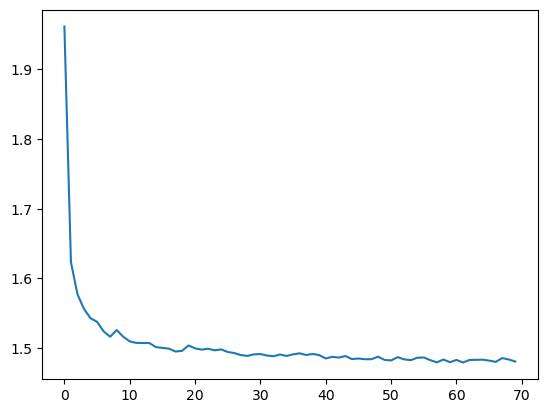

In [350]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

loss_hist = torch.tensor(training_loss).view(70, -1)
loss_hist = torch.mean(loss_hist, dim=1)
plt.plot(loss_hist)

Progress tracker:
- 1 layer NN with 10 epochs of training: 
    - test loss: 1.61052
    - test accuracy: 0.88704
    
- 2 layer NN with 64 size hidden layer, added AdamW optimizer:
    - test loss: 1.53824
    - test accuracy: 0.92038

- 2 layer NN with 128 size hidden layer: (practically no improvement)
    - test loss: 1.53825
    - test accuracy: 0.91929

- 2 layer NN with 64 size hidden layer, added relu after first layer: (relu was necessary ow just liek 1 layer NN)
    - test loss: 1.49081
    - test accuracy: 0.96865

- 3 layer NN with 128 size hidden layer: (architecture is limited)
    - test loss: 1.48965
    - test accuracy: 0.96785

- 1 layer CNN with kernel 3 and padding = 1 joined iwth 1 layer Linear layer: (( appears that regresses to 2 layer NN bc no abstraciton of data))
    - test loss: 1.53574
    - test accuracy: 0.92267

- 2 layer CNN with kernel 3, no padding and increasing channel by 2:
    - test loss: 1.49036
    - test accuracy: 0.96676

- added maxpooling with kernel size 2 in-between conv layers:
    - test loss: 1.49294
    - test accuracy: 0.96537

- relu inbetween convlution layers and deeper channels to 4 and 16: otherwise siimlar to single convlution layer:
    - test loss: 1.48902
    - test accuracy: 0.97014

- larger kernel size - 5:
    - test loss: 1.47957
    - test accuracy: 0.97850

- second linear layer:
    - test loss: 1.47536
    - test accuracy: 0.98278

- dropout for overfitting, only after dense layers: (possibly overfitting after running 10 epochs)
    - test loss: 1.47994
    - test accuracy: 0.97751

- dropout in between convolution layers 20 epoch before overfitting:
    - test loss: 1.47057
    - test accuracy: 0.98597

In [336]:
a = torch.randn(64, 1, 28, 28).to(device)
conv_layers = nn.Sequential(
            nn.Conv2d(1, 5, kernel_size=5, device=device),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(5, 25, kernel_size=5, device=device),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
lin_layer = nn.Linear(320, 10, device=device)
output = conv_layers(a)
print(output.shape)
output = lin_layer(output.view(-1, 320))
# logits = F.softmax(output, dim=1)

torch.Size([64, 25, 4, 4])
